In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use("ggplot")
import nltk

In [2]:
#Read the data
df = pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv")
print(df.shape)

(568454, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


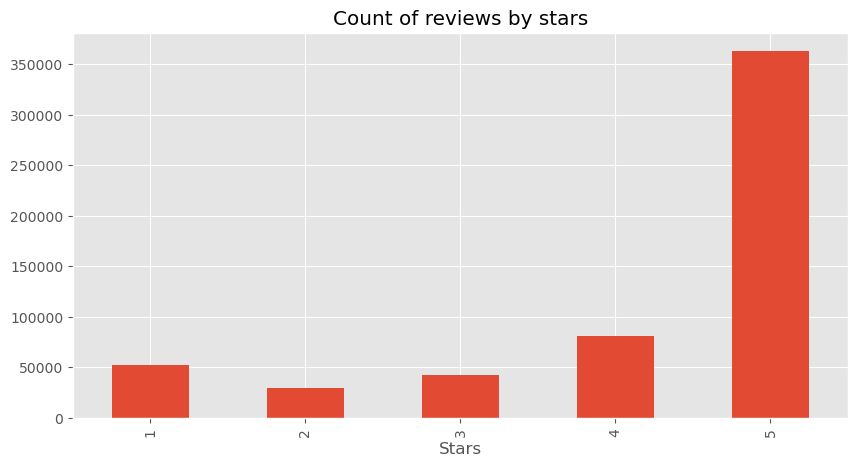

In [4]:
stars = df["Score"].value_counts().sort_index().plot(kind = "bar",
                                             title="Count of reviews by stars",
                                             figsize=(10,5))
stars.set_xlabel("Stars")
plt.show()

# **VADER Sentiment Analysis**

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm  #Progress bar tracker

sia = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [6]:
sia.polarity_scores("I am very happy")

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [ ]:
res = {}
for index,row in tqdm(df.iterrows(), total = len(df)):
    text = row["Text"]
    id = row["Id"]
    res[id] = sia.polarity_scores(text)
    


  0%|          | 0/568454 [00:00<?, ?it/s]

In [ ]:
vaders_result = pd.DataFrame(res).T
vaders_result = vaders_result.reset_index().rename(columns = {"index":"Id", "neg" : "vaders_neg", "pos" : "vaders_pos", "neu" : "vaders_neu"})
vaders_result = vaders_result.merge(df, how = 'left')

In [ ]:
#Sentiment score + meadata
vaders_result

In [ ]:
vaders_plot = sb.barplot(data = vaders_result, x="Score", y="compound")
vaders_plot.set_title("Star vs Compound score")
vaders_plot.set_xlabel("Stars")
vaders_plot.set_ylabel("Compound Score")
plt.show()
           

# **Roberta Sentiment Analysis**

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
def polarity_scores_roberta(data):
    encoded_text = tokenizer(data, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = { "roberta_neg" : scores[0], "roberta_neu" : scores[1], "roberta_pos" : scores[2] }
    return scores_dict

In [ ]:
res = {}
for index, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row["Text"]
        id = row["Id"]
        roberta_result = polarity_scores_roberta(text)
        res[id] = roberta_result
    except RuntimeError:
        print(f"Broke for id {id}")

In [ ]:
roberta_results = pd.DataFrame(res).T
roberta_results = roberta_results.reset_index().rename(columns={"index":"Id"})
roberta_results = roberta_results.merge(df, how = 'left')

# Compare scores between models

In [ ]:
combined_results = pd.DataFrame(res).T
combined_results = combined_results.reset_index().rename(columns={"index":"Id"})
combined_results = combined_results.merge(vaders_result, how = 'left')

In [ ]:
combined_results.columns

In [ ]:
sb.pairplot(data = combined_results, vars = ['roberta_neg', 'roberta_neu', 'roberta_pos', 'vaders_neg',
       'vaders_neu', 'vaders_pos'], hue = "Score", palette = "tab10")
plt.show()

# Examples where model scoring and review score vary the most

In [ ]:
combined_results.query("Score == 1").sort_values('roberta_pos', ascending = False)['Text'].values[0]

In [ ]:
combined_results.query("Score == 1").sort_values('vader_pos', ascending = False)['Text'].values[0]

In [ ]:
combined_results.query("Score == 5").sort_values('roberta_pos', ascending = False)['Text'].values[0]

In [ ]:
combined_results.query("Score == 5").sort_values('vader_pos', ascending = False)['Text'].values[0]